In [105]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import AdaBoostClassifier
import joblib

In [106]:
# Lettura dataset
data = pd.read_csv("train.csv", sep = ",")

In [107]:
# Feature aggregation: i Paesi sono stati raggruppati per continenti
asia = ["Philippines", "India", "South", "China", "Vietnam", "Japan", "Taiwan", "Iran", "Thailand", "Cambodia", "Laos", "Hong"]
europe = ["Germany", "England", "Italy", "Poland", "Portugal", "Greece", "France", "Ireland", "Yugoslavia", "Hungary", "Scotland", "Netherlands"]
north_america = ["USA", "Canada"]
central_america = ["Mexico", "Puerto-Rico", "El-Salvador", "Cuba", "Jamaica", "Dominican-Republic", "Guatemala", "Haiti", "Nicaragua", "Caribbean", "Honduras"]
south_america = ["Columbia", "Peru", "Ecuador"]

for i in range(len(data)):
    if data.loc[i, "F13"] in asia:
        data.F13.replace(data.loc[i, "F13"], "asia", inplace = True)
    elif data.loc[i, "F13"] in europe:
        data.F13.replace(data.loc[i, "F13"], "europe", inplace = True)
    elif data.loc[i, "F13"] in north_america:
        data.F13.replace(data.loc[i, "F13"], "north_america", inplace = True)
    elif data.loc[i, "F13"] in central_america:
        data.F13.replace(data.loc[i, "F13"], "central_america", inplace = True)
    elif data.loc[i, "F13"] in south_america:
        data.F13.replace(data.loc[i, "F13"], "south_america", inplace = True)

In [108]:
data.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,Y
0,39,K1,77516,R1,13,Q1,P1,M1,caucasian,Male,2174,0,40,north_america,0
1,50,K2,83311,R1,13,Q2,P2,M2,caucasian,Male,0,0,13,north_america,0
2,38,K3,215646,R2,9,Q3,P3,M1,caucasian,Male,0,0,40,north_america,0
3,53,K3,234721,R3,7,Q2,P3,M2,black,Male,0,0,40,north_america,0
4,28,K3,338409,R1,13,Q2,P4,M3,black,Female,0,0,40,central_america,0


In [109]:
# Colonne feature categoriche
colF1 = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8']
colF3 = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11', 'R12', 'R13', 'R14', 'R15', 'R16']
colF5 = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7']
colF6 = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14']
colF7 = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6']
colF8 = ['caucasian', 'black', 'asian', 'american', 'other']
colF9 = ['Male', 'Female']
colF13 = ['asia', 'europe', 'north_america', 'central_america', 'south_america']

# Codifica delle feature categoriche
data.F1.replace(colF1, [0, 1, 2, 3, 4, 5, 6, 7], inplace = True)
data.F3.replace(colF3, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], inplace = True)
data.F5.replace(colF5, [0, 1, 2, 3, 4, 5, 6], inplace = True)
data.F6.replace(colF6, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], inplace = True)
data.F7.replace(colF7, [0, 1, 2, 3, 4, 5], inplace = True)
data.F8.replace(colF8, [0, 1, 2, 3, 4], inplace = True)
data.F9.replace(colF9, [0, 1], inplace = True)
data.F13.replace(colF13, [0, 1, 2, 3, 4], inplace = True)

In [110]:
# Suddivisione tra feature e target
x_train = data.iloc[:, :-1].values
y_train = data.iloc[:, -1].values
print(x_train.shape)
print(y_train.shape)

(32561, 14)
(32561,)


In [111]:
# Imputazione dei valori NaN tramite SimpleImputer, con la strategia che sostituisce i valori mancanti con la moda dei valori della feature
print("SimpleImputer")
imp = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
x_train_notnan = imp.fit_transform(x_train)
print(x_train_notnan[pd.isna(x_train[:,0]),0][0:10])

SimpleImputer
[]


In [112]:
# Creazione DataFrame da insiemi di train dopo l'imputazione dei valori mancanti 
colF = ['F0','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13']

training_set_df = pd.DataFrame(x_train_notnan, columns = colF)

In [113]:
training_set_df.head()

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,39.0,0.0,77516.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,2174.0,0.0,40.0,2.0
1,50.0,1.0,83311.0,0.0,13.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,13.0,2.0
2,38.0,2.0,215646.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,40.0,2.0
3,53.0,2.0,234721.0,2.0,7.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,40.0,2.0
4,28.0,2.0,338409.0,0.0,13.0,1.0,3.0,2.0,1.0,1.0,0.0,0.0,40.0,3.0


In [114]:
# Codifica OneHot: i valori delle feature categoriche vengono codificati secondo la tecnica OneHot
# Si istanzia un Encoder per ogni feature categorica e si invoca il metodo fit per poi invocare il transform durante la predizione
categorical = ['F1','F3','F5','F6','F7','F8','F9', 'F13']
onehot_df = pd.DataFrame()
columns = [colF1, colF3, colF5, colF6, colF7, colF8, colF9, colF13]
categorical_df = pd.DataFrame()

for i in categorical:
    categorical_df = pd.concat([categorical_df, training_set_df[i]], axis = 1)

onehot_encoders = []
j = 0

# Creazione del dataframe con le colonne codificate
for i in categorical:
    # one hot encoding della colonna i
    onehot_enc = OneHotEncoder()
    temp = pd.DataFrame(categorical_df[i].values)
    onehot_enc.fit(temp)
    onehot_encoders.append(onehot_enc)

    transformed = onehot_enc.transform(temp)

    transformed_df = pd.DataFrame(transformed.toarray(), columns = columns[j], index = temp.index)

    onehot_df = pd.concat([onehot_df, transformed_df], axis = 1)
    j += 1

onehot_df.head(10)

,K1,K2,K3,K4,K5,K6,K7,K8,R1,R2,...,asian,american,other,Male,Female,asia,europe,north_america,central_america,south_america
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [115]:
# Unione con il DataFrame di partenza
training_set_df_oh = pd.concat([training_set_df, onehot_df], axis = 1)
training_set_df_oh = training_set_df_oh.drop(categorical, axis = 1)

training_set_df_oh.head(10)

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,asian,american,other,Male,Female,asia,europe,north_america,central_america,south_america
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,37.0,284582.0,14.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,49.0,160187.0,5.0,0.0,0.0,16.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7,52.0,209642.0,9.0,0.0,0.0,45.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,31.0,45781.0,14.0,14084.0,0.0,50.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,42.0,159449.0,13.0,5178.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [116]:
# DataFrame con i valori del target
y_training_df = pd.DataFrame(y_train, columns = ["Y"])

In [117]:
# Unione con il DataFrame successivo alla codifica OneHot
training_target_df = pd.concat([training_set_df_oh, y_training_df], axis = 1)

In [118]:
# Individuazione e rimozione degli outlier (in F2) nel training set
z_scores = stats.zscore(training_target_df["F2"])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
training_target_df = training_target_df[filtered_entries]

training_target_df.head()

,F0,F2,F4,F10,F11,F12,K1,K2,K3,K4,...,american,other,Male,Female,asia,europe,north_america,central_america,south_america,Y
0,39.0,77516.0,13.0,2174.0,0.0,40.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,53.0,234721.0,7.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [119]:
# Si ricavano x_train e y_train da questo DataFrame
x_train_notnan = training_target_df.iloc[:, :-1].values
print(x_train_notnan.shape)
y_train = training_target_df.iloc[:, -1].values
print(y_train.shape)

(32214, 69)
(32214,)


In [120]:
# Scaling con StandardScaler
print("StandardScaler")
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_notnan)

print("Media distribuzione di partenza: {}".format(np.mean(x_train_notnan, axis=0)))
print("Media distribuzione scalata: {}".format(np.mean(x_train_scaled, axis=0)))

print("Deviazione standard distribuzione di partenza: {}".format(np.std(x_train_notnan, axis=0)))
print("Deviazione standard distribuzione scalata: {}".format(np.std(x_train_scaled, axis=0)))

StandardScaler
Media distribuzione di partenza: [3.86152604e+01 1.85068537e+05 1.00848078e+01 1.07945136e+03
 8.76844229e+01 4.04416713e+01 3.98894890e-02 7.84751971e-02
 7.52747253e-01 2.94281989e-02 6.43198609e-02 3.44881108e-02
 4.34593655e-04 2.17296827e-04 1.64276402e-01 3.22437450e-01
 3.61023158e-02 5.29583411e-02 1.56764140e-02 2.24033029e-01
 3.29980754e-02 4.26522630e-02 1.98981809e-02 1.27584280e-02
 1.78183399e-02 1.01198237e-02 2.85279692e-02 5.09095424e-03
 1.52107779e-03 1.31309369e-02 3.27745701e-01 4.60389893e-01
 1.36524492e-01 1.27894704e-02 3.12597008e-02 6.82932886e-04
 3.06078103e-02 1.15663997e-01 1.25038803e-01 4.18451605e-02
 1.84298752e-01 1.01136152e-01 1.12342460e-01 1.25628609e-01
 4.88607438e-02 3.04525982e-02 6.15570870e-02 2.84037996e-02
 1.99292233e-02 2.79381635e-04 4.56323338e-03 2.55044391e-01
 4.05475880e-01 4.82709381e-02 1.55553486e-01 1.05606258e-01
 3.00490470e-02 8.55776991e-01 9.39032719e-02 3.22530577e-02
 9.65418762e-03 8.41249146e-03 6.6893

In [121]:
# Bilanciamento del training set
smote = SMOTE(random_state = 0, sampling_strategy = 'not majority', k_neighbors = 10, n_jobs = -1)
x_train_scaled, y_train = smote.fit_resample(x_train_scaled, y_train)
print(x_train_scaled.shape, y_train.shape)
print(x_train_scaled)

(48906, 69) (48906,)
[[ 0.02818334 -1.13747952  1.13409202 ...  0.29766597 -0.20025168
  -0.05959364]
 [ 0.83396665 -1.07619139  1.13409202 ...  0.29766597 -0.20025168
  -0.05959364]
 [-0.04506969  0.32338835 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]
 ...
 [-0.69084479 -1.60377104 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]
 [-0.02490731  0.87173017  0.7450638  ...  0.29766597 -0.20025168
  -0.05959364]
 [ 0.68179709 -0.12037052 -0.42202087 ...  0.29766597 -0.20025168
  -0.05959364]]


array([[<AxesSubplot:title={'center':'Y'}>]], dtype=object)

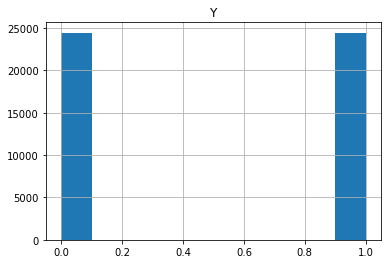

In [122]:
# DataFrame del target bilanciato, con controllo
y_training_df = pd.DataFrame(y_train, columns = ["Y"])
y_training_df.hist()

perché scelta del classificatore

In [123]:
# Classificazione mediante AdaBoostClassifier
classifierADA = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

grid = dict()

grid['n_estimators'] =  np.arange(100, 850, 250)
grid['learning_rate'] = [.01, 1]
grid['base_estimator__max_depth'] = [2, 5]
grid['base_estimator__min_samples_split'] = [2, 3, 5]
grid['base_estimator__min_samples_leaf'] = [2, 5, 10]

# Impostazione K-Fold Cross Validation
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 1, random_state = 1)

# Procedura Grid Search
grid_search = GridSearchCV(estimator = classifierADA, param_grid = grid, n_jobs = -1, cv = cv, scoring = 'accuracy')
grid_fit = grid_search.fit(x_train_scaled, y_train)

# Individuazione miglior modello
print("Best: %f using %s" % (grid_fit.best_score_ , grid_fit.best_params_))

In [ ]:
# Istanziazione del miglior classificatore
bestclf = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 2, min_samples_split = 2, min_samples_leaf = 5), learning_rate = 1, n_estimators = 1000)

In [ ]:
# Addestramento del miglior classificatore sul training set
bestclf.fit(x_train_scaled, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=5),
                   learning_rate=1, n_estimators=1000)

In [ ]:
# Predizione sul training set
y_pred = bestclf.predict(x_train_scaled)

0.9368380157853842


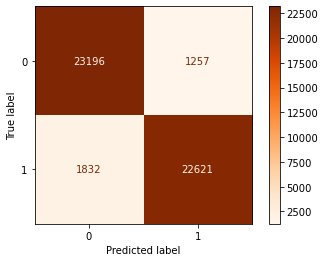

In [ ]:
# Visualizzazione risultati sul training set (accuratezza)
CM_ADA = confusion_matrix(y_train, y_pred)
PercADA = (CM_ADA[0,0] + CM_ADA[1,1])/CM_ADA.sum()

cmd = ConfusionMatrixDisplay(CM_ADA)
cmd.plot(cmap = "Oranges")

print(PercADA)

In [ ]:
# Salvo tutti gli oggetti addestrati
joblib.dump(imp, "pickles/imputer.pkl")
joblib.dump(scaler, "pickles/scaler.pkl")
joblib.dump(bestclf, "pickles/model.pkl")
for i in range(len(onehot_encoders)):
    joblib.dump(onehot_encoders[i], f"pickles/ohenc-ohe{i}.pkl")